In [1]:
import pandas as pd
import datetime
from os import listdir
import os, os.path
from os.path import isfile, join
import numpy as np
import csv
import re
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.util import dataframe_utils
import matplotlib.pyplot as plt
import seaborn as sns
#import pingouin as pg

In [2]:
df_prueba = pd.read_csv("Log of analysis of time aspects.csv",index_col=0)

df_prueba["Year"]=df_prueba["Year"].apply(str)

In [6]:
df_analisis = df_prueba.groupby(by=['case:concept:name'])
# columns=['case:concept:name','Operations','Organization', 'Year', 'Question']
df_agrupado = pd.DataFrame(columns=['case:concept:name','Operations', 'Year', 'Question'])
for name, group in df_analisis:
#     org = group.iloc[0]['Organization']
    year = group.iloc[0]['Year']
    question = group.iloc[0]['Question']
    lista = group['concept:name'].to_list()
        
    new_row={'case:concept:name':name, 'Operations':lista, 'Year':year, 'Question':question} 
    df_agrupado = df_agrupado.append(new_row, ignore_index=True)
    
df_agrupado

,case:concept:name,Operations,Year,Question
0,A1 P1 BPI 2017,"[Calculate cycle time, Calculate cycle time, F...",2017,P1
1,A1 P1 BPI 2020,"[Filter traces, Calculate cycle time, Calculat...",2020,P1
2,A1 P2 BPI 2019,"[Group events by time, Calculate cycle time, R...",2019,P2
3,A1 P2 BPI 2020,"[Calculate cycle time, Compare cycle time]",2020,P2
4,A1 P5 BPI 2015,"[Calculate cycle time, Identify organizational...",2015,P5
...,...,...,...,...
121,A8 P1 BPI 2017,"[Filter traces, Calculate waiting time, Repres...",2017,P1
122,A8 P5 BPI 2015,"[Calculate cycle time, Compare cycle time, Gro...",2015,P5
123,A9 P1 BPI 2017,"[Calculate processing time, Calculate waiting ...",2017,P1
124,A9 P2 BPI 2019,"[Filter traces, Calculate cycle time, Identify...",2019,P2


In [7]:
def overlapIndex(list1,list2):
    set1=set(list1)
    set2=set(list2)
    intersection = set1.intersection(set2)
    len1=len(list(set1))
    len2=len(list(set2))
#     print(float(len(list(intersection))))
#     print(min([len1,len2]))
    overlapIndex=float(len(list(intersection)))/min([len1,len2])
    return overlapIndex

def jaccardIndex(list1,list2):
    set1=set(list1)
    set2=set(list2)
    intersection = set1.intersection(set2)
    tamIntersection=len(list(intersection))
    union = set1.union(set2)
    tamUnion=len(list(union))
#     print("similitud: "+str(float(tamIntersection)/tamUnion))
    return float(tamIntersection)/tamUnion

def sorensenIndex(list1,list2):
    set1=set(list1)
    set2=set(list2)
    intersection = set1.intersection(set2)
    len1=len(list(set1))
    len2=len(list(set2))
    sorensenIndex=float(2*len(list(intersection)))/(len1+len2)
    return sorensenIndex

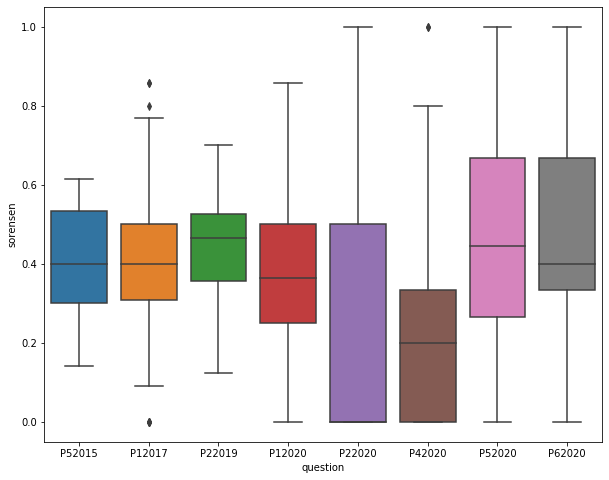

In [8]:
#enfrentando analisis que contestan a una misma pregunta
df2 = df_agrupado.groupby(by=['Year', 'Question'])
columns=['analisis','question','overlap', 'jaccard', 'sorensen']
df_metricas_preguntas = pd.DataFrame(columns=columns)

for name, group in df2:
    for i in range(len(group)):
        for j in range(i+1,len(group)):
            grupo = group.iloc[i]['Operations']
            analisis = group.iloc[i]['case:concept:name'] + "-" + group.iloc[j]['case:concept:name']
            question = name[1] + name[0]
            sorensen = sorensenIndex(grupo,group.iloc[j]['Operations'])
            overlap = overlapIndex(grupo,group.iloc[j]['Operations'])
            jaccard = jaccardIndex(grupo,group.iloc[j]['Operations'])
            new_row={'analisis':analisis, 'question':question, 'overlap': overlap, 'jaccard':jaccard, 'sorensen':sorensen} 
            df_metricas_preguntas = df_metricas_preguntas.append(new_row, ignore_index=True)
            
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 8)
ax = sns.boxplot(x="question", y="sorensen", data=df_metricas_preguntas)

In [9]:
#enfrentando todos los analisis con todos
df2 = df_agrupado
columns=['analisis','question','overlap', 'jaccard', 'sorensen']
df_metricas_preguntas = pd.DataFrame(columns=columns)

for i in range(len(df2)):       
    for j in range(i+1,len(df2)):
        grupo = df2.iloc[i]['Operations']
        analisis = df2.iloc[i]['case:concept:name'] + "-" + df2.iloc[j]['case:concept:name']
        question = df2.iloc[i]['Question'] + df2.iloc[i]['Year'] +"-"+ df2.iloc[j]['Question'] + df2.iloc[j]['Year']
        sorensen = sorensenIndex(grupo,df2.iloc[j]['Operations'])
        overlap = overlapIndex(grupo,df2.iloc[j]['Operations'])
        jaccard = jaccardIndex(grupo,df2.iloc[j]['Operations'])
        new_row={'analisis':analisis, 'question':question, 'overlap': overlap, 'jaccard':jaccard, 'sorensen':sorensen} 
        df_metricas_preguntas = df_metricas_preguntas.append(new_row, ignore_index=True)

In [10]:
df_metricas_preguntas

,analisis,question,overlap,jaccard,sorensen
0,A1 P1 BPI 2017-A1 P1 BPI 2020,P12017-P12020,0.333333,0.125000,0.222222
1,A1 P1 BPI 2017-A1 P2 BPI 2019,P12017-P22019,0.333333,0.153846,0.266667
2,A1 P1 BPI 2017-A1 P2 BPI 2020,P12017-P22020,0.500000,0.142857,0.250000
3,A1 P1 BPI 2017-A1 P5 BPI 2015,P12017-P52015,0.333333,0.166667,0.285714
4,A1 P1 BPI 2017-A1 P5 BPI 2020,P12017-P52020,1.000000,0.333333,0.500000
...,...,...,...,...,...
7870,A8 P5 BPI 2015-A9 P2 BPI 2019,P52015-P22019,0.375000,0.214286,0.352941
7871,A8 P5 BPI 2015-A9 P5 BPI 2015,P52015-P52015,0.625000,0.416667,0.588235
7872,A9 P1 BPI 2017-A9 P2 BPI 2019,P12017-P22019,0.142857,0.071429,0.133333
7873,A9 P1 BPI 2017-A9 P5 BPI 2015,P12017-P52015,0.142857,0.071429,0.133333


In [11]:
df_metricas_preguntas.mean()

C:\Users\maria\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


overlap     0.428697
jaccard     0.181352
sorensen    0.278797
dtype: float64

In [12]:
df_metricas_preguntas.describe()

,overlap,jaccard,sorensen
count,7875.000000,7875.000000,7875.000000
mean,0.428697,0.181352,0.278797
std,0.323275,0.160646,0.211582
min,0.000000,0.000000,0.000000
25%,0.166667,0.071429,0.133333
50%,0.500000,0.166667,0.285714
75%,0.666667,0.250000,0.400000
max,1.000000,1.000000,1.000000


In [13]:
df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P52015':'P52015-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P52015':'P52015-P52020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P42020-P52015':'P52015-P42020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P22020-P52015':'P52015-P22020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P12020-P52015':'P52015-P12020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P12017':'P12017-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P12017':'P12017-P52020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P42020-P12017':'P12017-P42020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P22020-P12017':'P12017-P22020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P12020-P12017':'P12017-P12020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P22019':'P22019-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P22019':'P22019-P52020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P42020-P22019':'P22019-P42020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P22020-P22019':'P22019-P22020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P12020-P22019':'P22019-P12020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P12017-P52015':'P52015-P12017'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P22019-P52015':'P52015-P22019'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P22019-P12017':'P12017-P22019'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P12020':'P12020-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P12020':'P12020-P52020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P42020-P12020':'P12020-P42020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P22020-P12020':'P12020-P22020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P22020':'P22020-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P22020':'P22020-P52020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P42020-P22020':'P22020-P42020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P42020':'P22020-P62020'})
df_metricas_preguntas = df_metricas_preguntas.replace({'P52020-P42020':'P22020-P52020'})

df_metricas_preguntas = df_metricas_preguntas.replace({'P62020-P52020':'P52020-P62020'})

In [14]:
df_metricas_preguntas.groupby(['question']).mean()

,overlap,jaccard,sorensen
question,,,
P12017-P12017,0.558486,0.274885,0.414164
P12017-P12020,0.374931,0.146728,0.241062
P12017-P22019,0.426859,0.197833,0.311606
P12017-P22020,0.226679,0.074196,0.125208
P12017-P42020,0.388615,0.136929,0.221419
P12017-P52020,0.580003,0.234209,0.361152
P12017-P62020,0.594567,0.219390,0.341428
P12020-P12020,0.492063,0.232647,0.352898
P12020-P22020,0.339327,0.152047,0.226348


In [15]:
df_metricas_preguntas.groupby(['question']).var(ddof=0)

C:\Users\maria\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  """Entry point for launching an IPython kernel.


,overlap,jaccard,sorensen
question,,,
P12017-P12017,0.050370,0.018178,0.026660
P12017-P12020,0.079001,0.011615,0.025420
P12017-P22019,0.055678,0.017239,0.029752
P12017-P22020,0.070404,0.008698,0.022409
P12017-P42020,0.119413,0.015091,0.032950
P12017-P52020,0.084543,0.017698,0.029671
P12017-P62020,0.095590,0.017246,0.029876
P12020-P12020,0.091253,0.023376,0.040301
P12020-P22020,0.130217,0.032660,0.058946


In [16]:
df_metricas_preguntas.groupby(['question']).std(ddof=0)

,overlap,jaccard,sorensen
question,,,
P12017-P12017,0.224433,0.134824,0.163280
P12017-P12020,0.281071,0.107775,0.159437
P12017-P22019,0.235962,0.131297,0.172488
P12017-P22020,0.265338,0.093260,0.149696
P12017-P42020,0.345561,0.122845,0.181521
P12017-P52020,0.290763,0.133032,0.172252
P12017-P62020,0.309177,0.131323,0.172847
P12020-P12020,0.302081,0.152892,0.200751
P12020-P22020,0.360856,0.180722,0.242789
